# Complex model

In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd


NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, 160.0)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(64):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# start

Epoch 0: Critic error ([73.54384779965307]) Generator err ([0.11666268110275269])


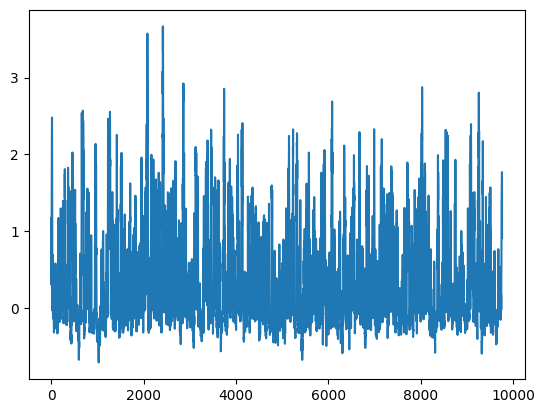

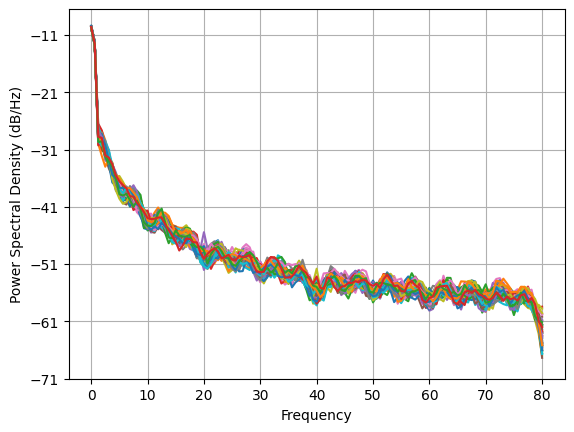

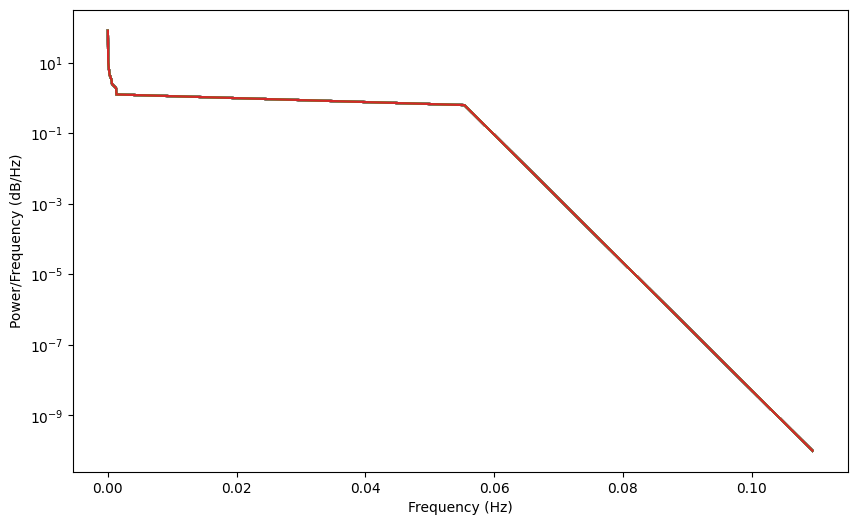

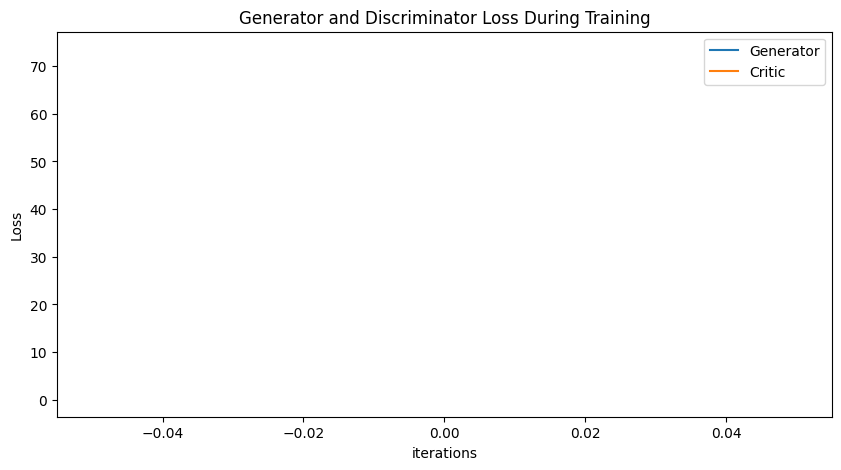

Epoch 10: Critic error ([73.54384779965307, 27.99042536814032, 14.669816943430959, 9.118903009491838, 7.090102600583151, 5.033995372450587, 4.238835072284883, 3.2945935495688103, 2.9770157069855214, 2.5232946649011248, 2.3566782167999563]) Generator err ([0.11666268110275269, 0.08961224555969238, 0.03910519555211067, 0.016156986355781555, 0.040084969252347946, 0.03113536722958088, 0.004884047899395227, -0.0886598601937294, -0.1202068105340004, -0.1702653020620346, -0.20367522537708282])


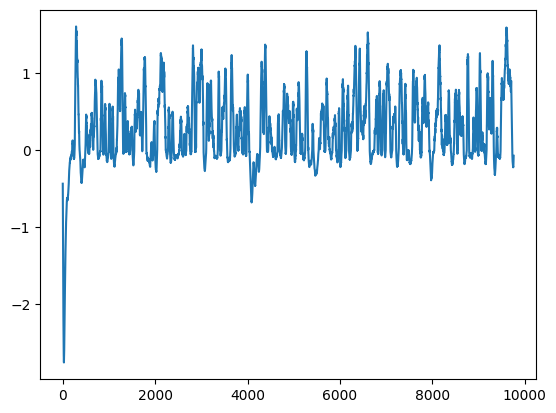

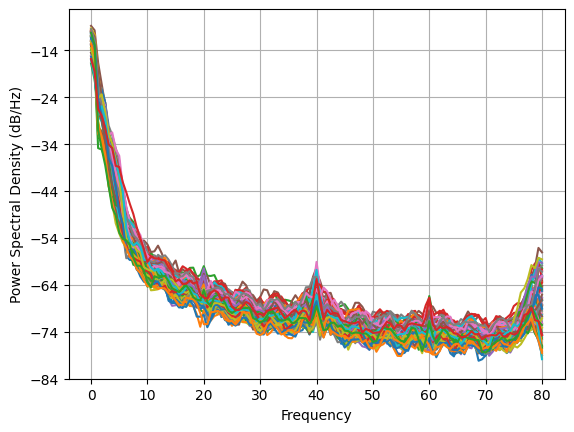

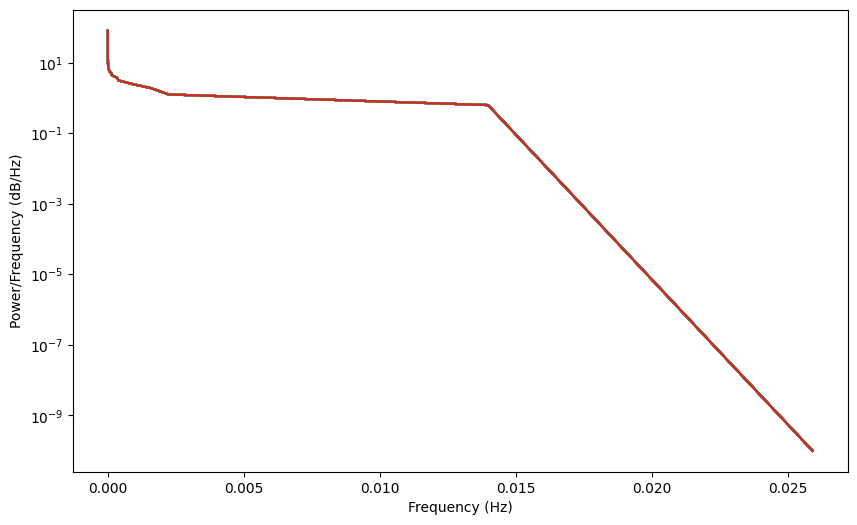

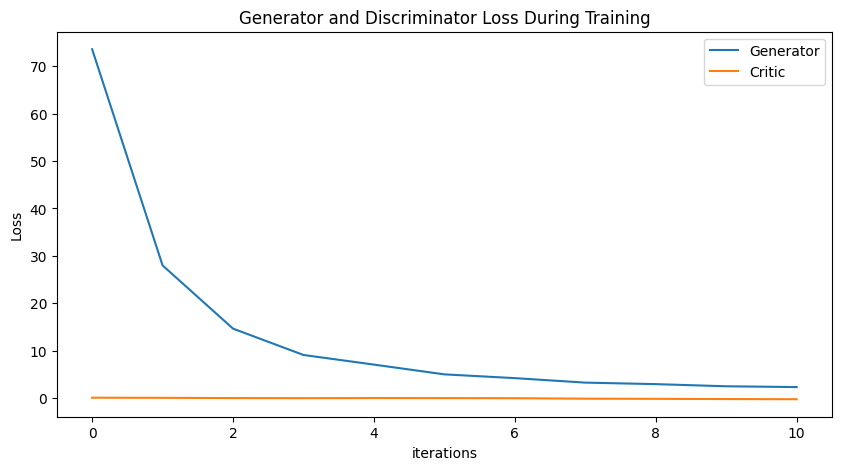

Epoch 20: Critic error ([73.54384779965307, 27.99042536814032, 14.669816943430959, 9.118903009491838, 7.090102600583151, 5.033995372450587, 4.238835072284883, 3.2945935495688103, 2.9770157069855214, 2.5232946649011248, 2.3566782167999563, 2.0921460478593135, 1.782972704409287, 1.5806927115863765, 1.3082385697706376, 1.2117958854801076, 0.9796856516866428, 0.9622493863987374, 0.7864034702489326, 0.7940883761254203, 0.7134804087652136]) Generator err ([0.11666268110275269, 0.08961224555969238, 0.03910519555211067, 0.016156986355781555, 0.040084969252347946, 0.03113536722958088, 0.004884047899395227, -0.0886598601937294, -0.1202068105340004, -0.1702653020620346, -0.20367522537708282, -0.21193140745162964, -0.1862376183271408, -0.13531959056854248, -0.1254504919052124, -0.1564965844154358, -0.15946538746356964, -0.14804525673389435, -0.12313961982727051, -0.1487758606672287, -0.13949549198150635])


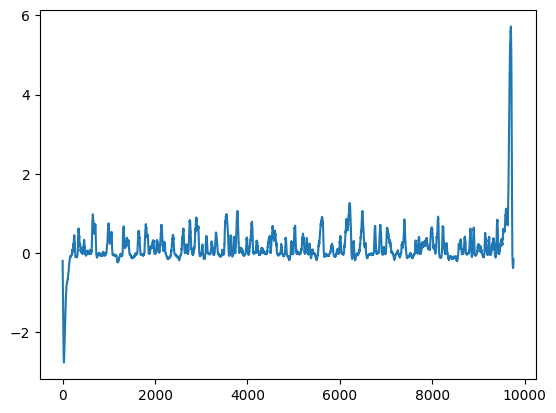

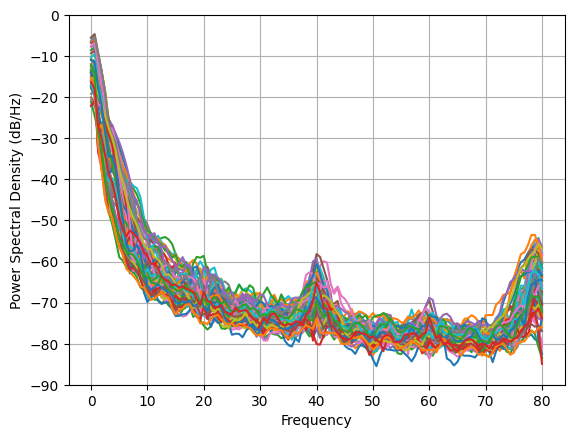

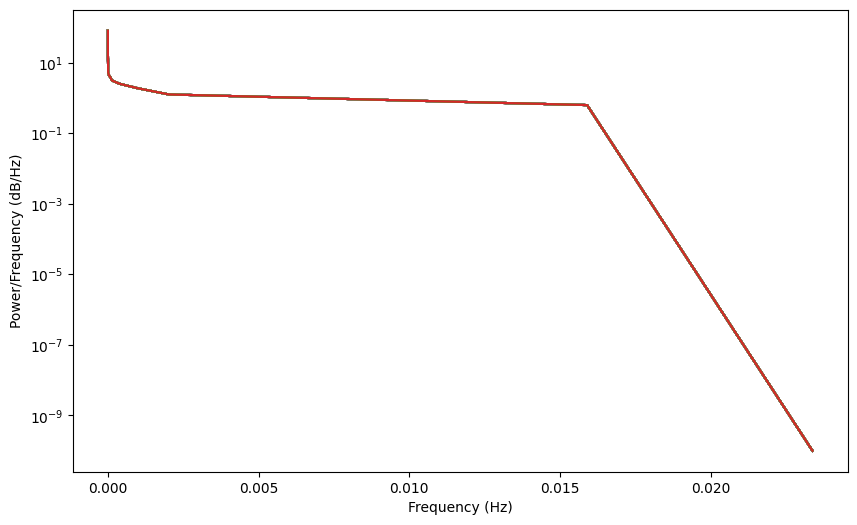

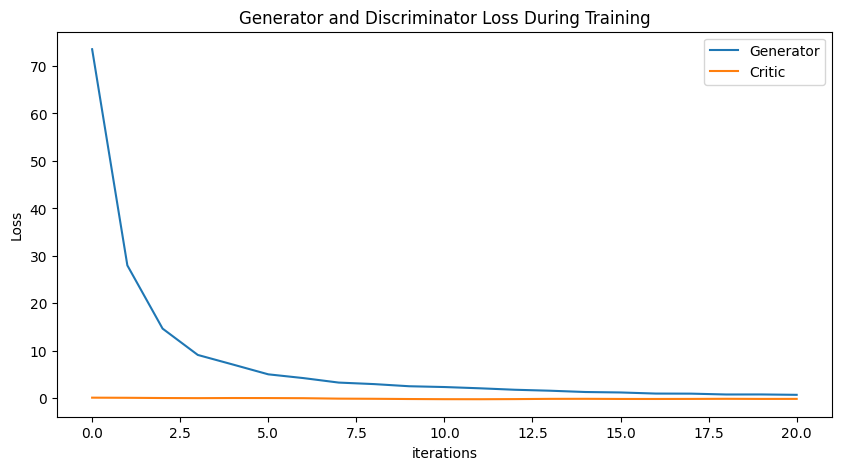

Epoch 30: Critic error ([73.54384779965307, 27.99042536814032, 14.669816943430959, 9.118903009491838, 7.090102600583151, 5.033995372450587, 4.238835072284883, 3.2945935495688103, 2.9770157069855214, 2.5232946649011248, 2.3566782167999563, 2.0921460478593135, 1.782972704409287, 1.5806927115863765, 1.3082385697706376, 1.2117958854801076, 0.9796856516866428, 0.9622493863987374, 0.7864034702489326, 0.7940883761254203, 0.7134804087652136, 0.6217534749214695, 0.48275530071124684, 0.4021353334514506, 0.2786442005876343, 0.25649907799982913, 0.23877460252225557, 0.16189934658332164, 0.15510056308172737, 0.12991905541095322, 0.09837379675780855]) Generator err ([0.11666268110275269, 0.08961224555969238, 0.03910519555211067, 0.016156986355781555, 0.040084969252347946, 0.03113536722958088, 0.004884047899395227, -0.0886598601937294, -0.1202068105340004, -0.1702653020620346, -0.20367522537708282, -0.21193140745162964, -0.1862376183271408, -0.13531959056854248, -0.1254504919052124, -0.15649658441543

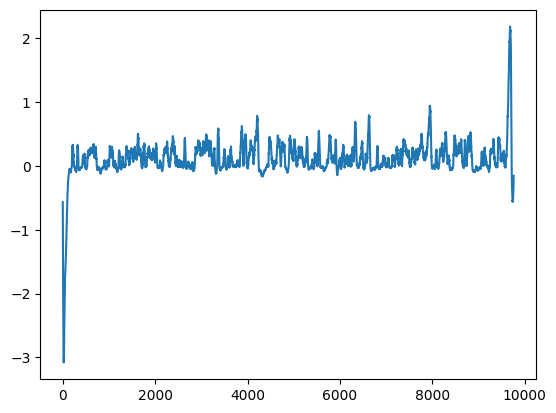

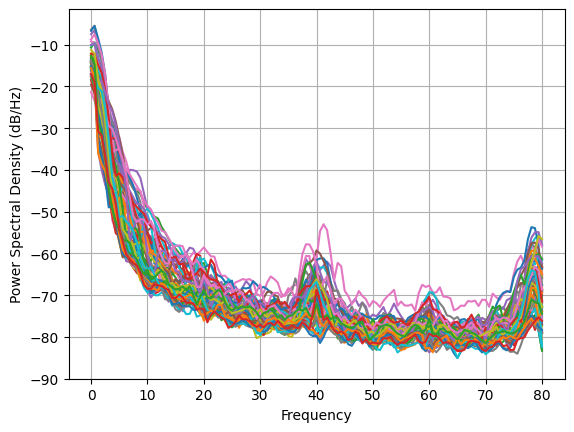

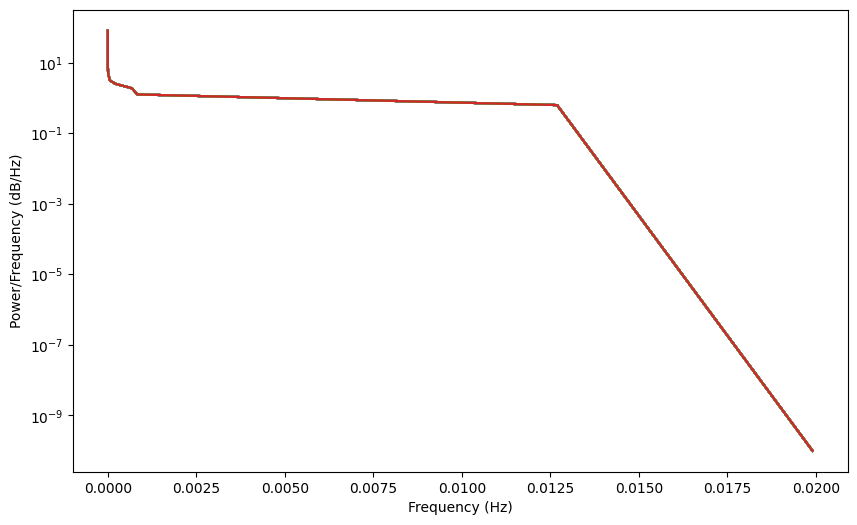

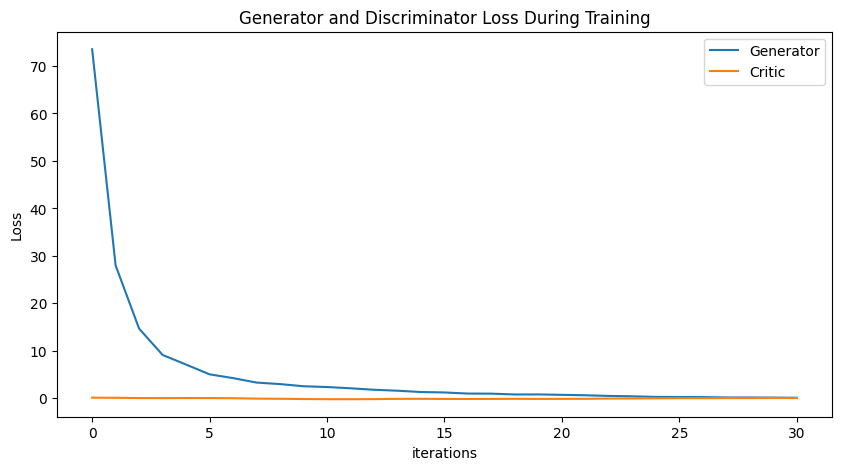

Epoch 40: Critic error ([73.54384779965307, 27.99042536814032, 14.669816943430959, 9.118903009491838, 7.090102600583151, 5.033995372450587, 4.238835072284883, 3.2945935495688103, 2.9770157069855214, 2.5232946649011248, 2.3566782167999563, 2.0921460478593135, 1.782972704409287, 1.5806927115863765, 1.3082385697706376, 1.2117958854801076, 0.9796856516866428, 0.9622493863987374, 0.7864034702489326, 0.7940883761254203, 0.7134804087652136, 0.6217534749214695, 0.48275530071124684, 0.4021353334514506, 0.2786442005876343, 0.25649907799982913, 0.23877460252225557, 0.16189934658332164, 0.15510056308172737, 0.12991905541095322, 0.09837379675780855, 0.07994264647262311, 0.05844618958702255, 0.036898252552935024, 0.03744062234545395, 0.02407201495896158, -0.00648717322245404, -0.017669446741575695, -0.03958009773139674, -0.045016953925416284, -0.05287943018915721]) Generator err ([0.11666268110275269, 0.08961224555969238, 0.03910519555211067, 0.016156986355781555, 0.040084969252347946, 0.03113536722

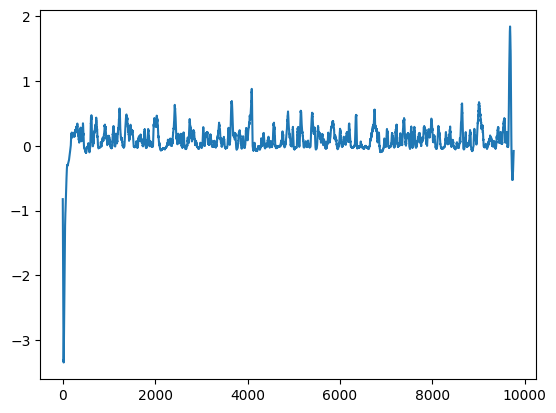

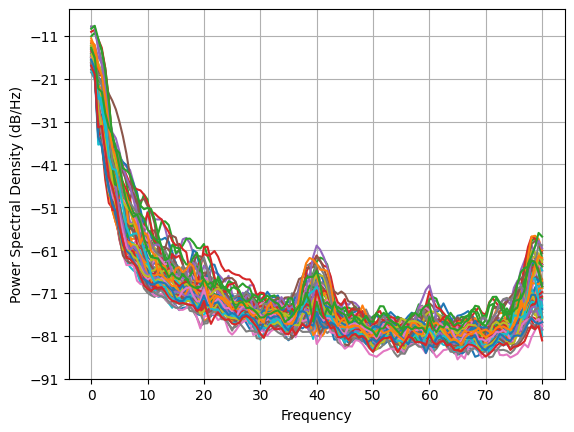

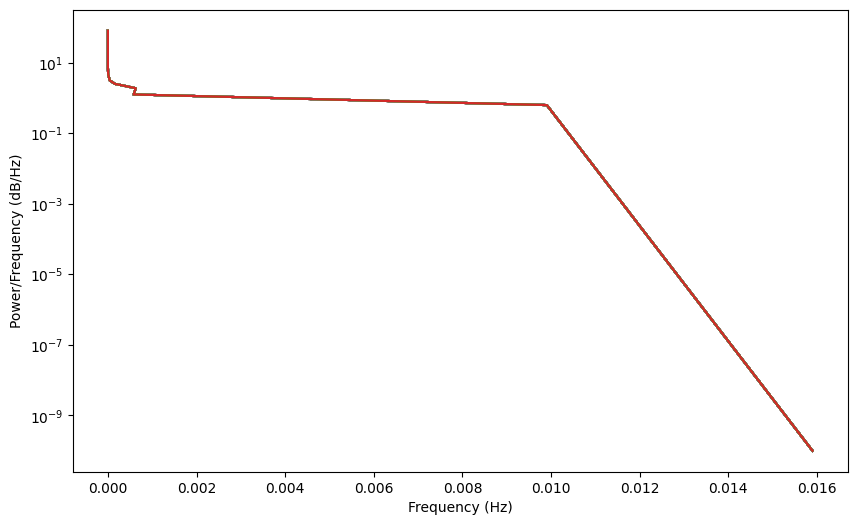

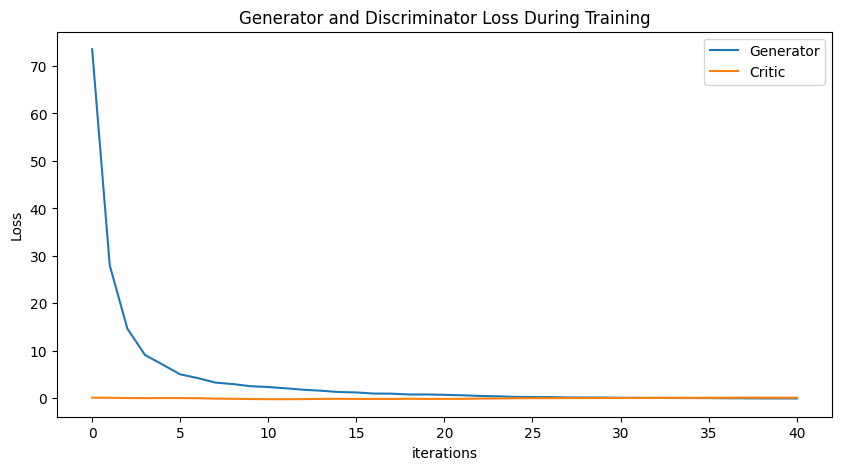

Epoch 50: Critic error ([73.54384779965307, 27.99042536814032, 14.669816943430959, 9.118903009491838, 7.090102600583151, 5.033995372450587, 4.238835072284883, 3.2945935495688103, 2.9770157069855214, 2.5232946649011248, 2.3566782167999563, 2.0921460478593135, 1.782972704409287, 1.5806927115863765, 1.3082385697706376, 1.2117958854801076, 0.9796856516866428, 0.9622493863987374, 0.7864034702489326, 0.7940883761254203, 0.7134804087652136, 0.6217534749214695, 0.48275530071124684, 0.4021353334514506, 0.2786442005876343, 0.25649907799982913, 0.23877460252225557, 0.16189934658332164, 0.15510056308172737, 0.12991905541095322, 0.09837379675780855, 0.07994264647262311, 0.05844618958702255, 0.036898252552935024, 0.03744062234545395, 0.02407201495896158, -0.00648717322245404, -0.017669446741575695, -0.03958009773139674, -0.045016953925416284, -0.05287943018915721, -0.05758588332397099, -0.07960472133140982, -0.08663900327936838, -0.09372542468053786, -0.09953295659668292, -0.11984791585401083, -0.11

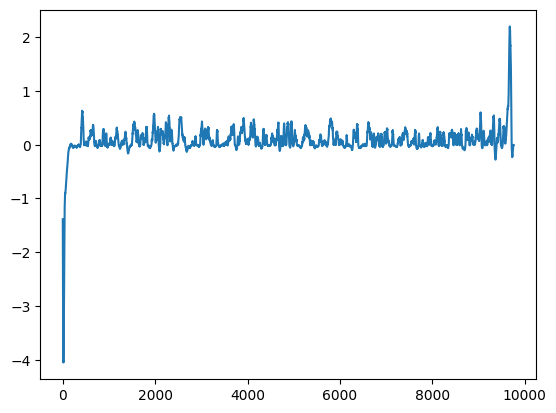

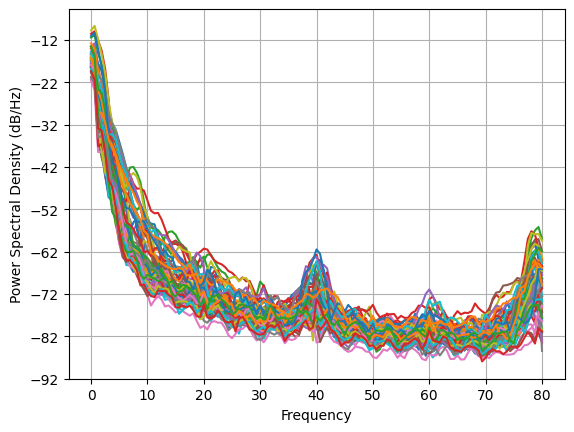

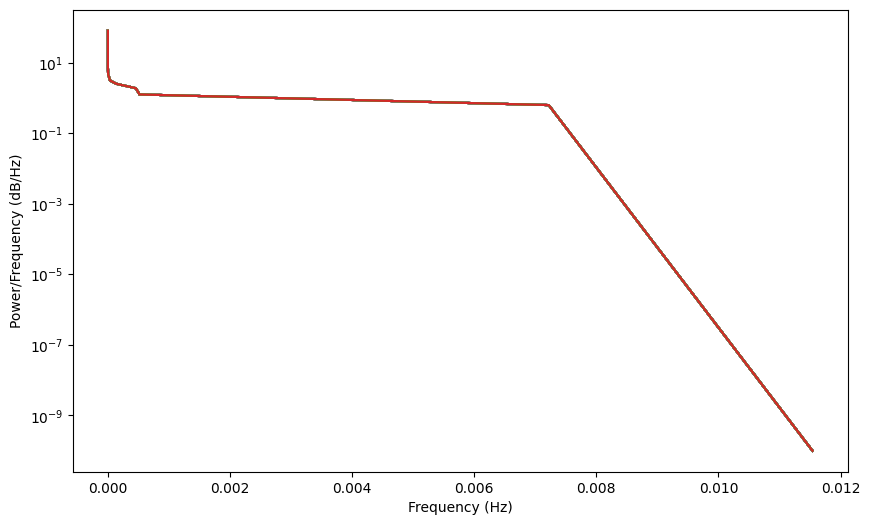

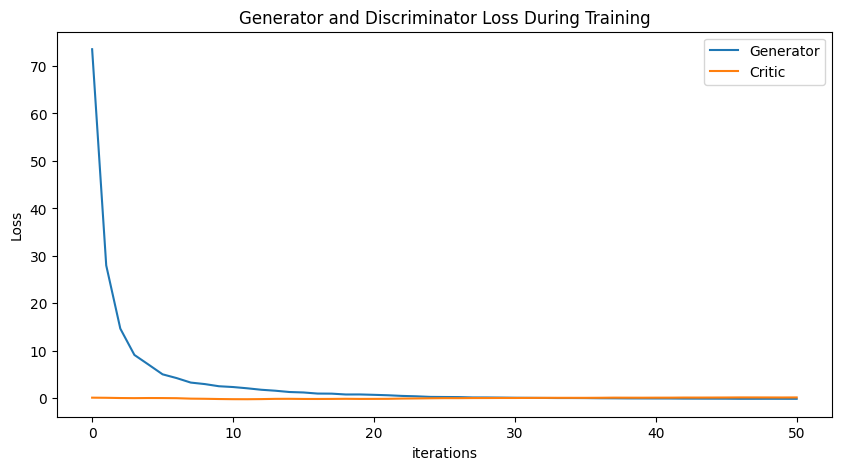

In [ ]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_closed.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator_eyes_closed.pt')
torch.save(disc, 'discriminator_eyes_closed.pt')
np.save('640channels-closed.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None

In [ ]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 10
training_data = torch.tensor(np.load('training_open.npy'))
BATCH_SIZE = np.shape(training_data)[0]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(640, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 640, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(640, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 640, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_open, disc, gen = train()

torch.save(gen, 'generator_eyes_open.pt')
torch.save(disc, 'discriminator_eyes_open.pt')
np.save('640channels-open.npy', generated_data_open.detach())
plot_everything(generated_data_open, gen_err, critic_err)
generated_data_open = None